# 🍷 Clasificación de vinos – Wine Quality (Red)

Proyecto 2 – Inteligencia Artificial, UCR.

En este notebook se entrena y evalúa la capacidad de cuatro modelos clásicos de clasificación binaria para predecir si un vino tinto es de **buena calidad** (`good_wine = 1`) a partir de variables fisicoquímicas.

Modelos usados:
- Regresión Logística
- Árbol de Decisión
- k-Nearest Neighbors (kNN)
- Red Neuronal Multicapa (MLP)

Al final se incluye una evaluación con **múltiples splits (5 seeds)** para analizar estabilidad y generalización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

## 1. Cargar dataset de vinos

In [2]:
# Ajusta la ruta si tu archivo está en otro lugar
df = pd.read_csv("../Datasets/processed/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## 2. Crear variable objetivo binaria `good_wine`

- `good_wine = 1` si `quality >= 7`
- `good_wine = 0` en caso contrario

In [4]:
df["good_wine"] = (df["quality"] >= 7).astype(int)
df["good_wine"].value_counts(), df["good_wine"].value_counts(normalize=True).round(3)

(good_wine
 0    1382
 1     217
 Name: count, dtype: int64,
 good_wine
 0    0.864
 1    0.136
 Name: proportion, dtype: float64)

## 3. Definir `X` e `y` y dividir en train/test

In [5]:
feature_cols = [
    "fixed acidity", "volatile acidity", "citric acid",
    "residual sugar", "chlorides", "free sulfur dioxide",
    "total sulfur dioxide", "density", "pH",
    "sulphates", "alcohol"
]

X = df[feature_cols].copy()
y = df["good_wine"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((1279, 11), (320, 11))

## 4. Escalado de variables

Usamos `StandardScaler` para los modelos sensibles a la escala (LogReg, kNN, MLP).

In [6]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## 5. Definir modelos a comparar

In [7]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "MLP": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)
}
models

{'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=2000),
 'DecisionTree': DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42),
 'KNN': KNeighborsClassifier(n_neighbors=15),
 'MLP': MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)}

## 6. Entrenamiento y evaluación en un solo split (seed=42)

In [8]:
results = []
probas = {}

for name, clf in models.items():
    print(f"\nEntrenando {name}...")
    
    if name in ["KNN", "LogisticRegression", "MLP"]:
        clf.fit(X_train_s, y_train)
        y_pred = clf.predict(X_test_s)
        y_proba = clf.predict_proba(X_test_s)[:, 1]
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "modelo": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    })
    probas[name] = y_proba

results_wine = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_wine


Entrenando LogisticRegression...

Entrenando DecisionTree...

Entrenando KNN...

Entrenando MLP...


/home/mario/Desktop/UCR/zhai-detector/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,modelo,accuracy,precision,recall,f1,roc_auc
3,MLP,0.91250,0.692308,0.627907,0.658537,0.909495
1,DecisionTree,0.83125,0.428571,0.767442,0.550000,0.859164
0,LogisticRegression,0.81250,0.400000,0.790698,0.531250,0.882378
2,KNN,0.89375,0.695652,0.372093,0.484848,0.853581


## 7. Curvas ROC de los modelos (Wine)

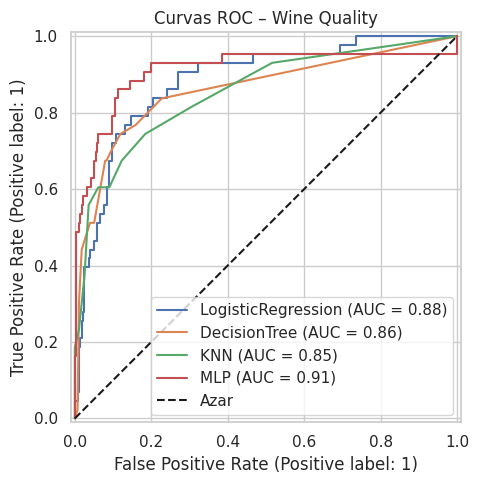

In [9]:
plt.figure(figsize=(7, 5))
for name, y_proba in probas.items():
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=plt.gca())

plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.title("Curvas ROC – Wine Quality")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Matriz de confusión del mejor modelo (por F1)

In [10]:
best_name = results_wine.iloc[0]["modelo"]
best_name

'MLP'

/home/mario/Desktop/UCR/zhai-detector/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


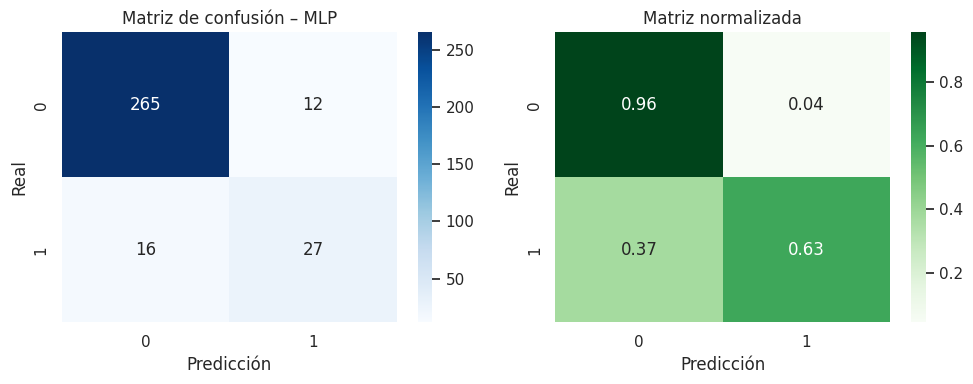

In [11]:
best_clf = models[best_name]

if best_name in ["KNN", "LogisticRegression", "MLP"]:
    best_clf.fit(X_train_s, y_train)
    y_pred_best = best_clf.predict(X_test_s)
else:
    best_clf.fit(X_train, y_train)
    y_pred_best = best_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title(f"Matriz de confusión – {best_name}")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens", ax=ax[1])
ax[1].set_title("Matriz normalizada")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")

plt.tight_layout()
plt.show()

## 9. Validación con múltiples splits (5 seeds)

Ahora repetimos el experimento con 5 particiones diferentes del dataset para evaluar la estabilidad de cada modelo.

In [12]:
SEEDS = [10, 20, 30, 40, 50]
rows = []

for seed in SEEDS:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    for name, base_model in models.items():
        clf = clone(base_model)
        
        if name in ["KNN", "LogisticRegression", "MLP"]:
            clf.fit(X_train_s, y_train)
            y_pred = clf.predict(X_test_s)
            y_proba = clf.predict_proba(X_test_s)[:, 1]
        else:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]
        
        rows.append({
            "modelo": name,
            "seed": seed,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_test, y_proba)
        })

df_splits_wine = pd.DataFrame(rows)

summary_wine = df_splits_wine.groupby("modelo").agg(["mean", "std"])
summary_wine

/home/mario/Desktop/UCR/zhai-detector/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mario/Desktop/UCR/zhai-detector/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mario/Desktop/UCR/zhai-detector/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mario/Desktop/UCR/zhai-detector/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimiza

seed             accuracy           precision            \
                    mean        std      mean       std      mean       std   
modelo                                                                        
DecisionTree        30.0  15.811388  0.776250  0.021718  0.335387  0.037902   
KNN                 30.0  15.811388  0.861875  0.016447  0.487944  0.080370   
LogisticRegression  30.0  15.811388  0.785625  0.027652  0.368293  0.039170   
MLP                 30.0  15.811388  0.890000  0.014557  0.608192  0.070524   

                      recall                  f1             roc_auc            
                        mean       std      mean       std      mean       std  
modelo                                                                          
DecisionTree        0.679070  0.124587  0.447566  0.054463  0.770817  0.063780  
KNN                 0.348837  0.023256  0.405812  0.042831  0.837713  0.039698  
LogisticRegression  0.818605  0.055522  0.507641  0.046168  0.872739  0.033052  
MLP                 0.525581  0.060644  0.562050  0.053464  0.877945  0.037402